In [72]:
import numpy as np
from sympy import symbols, Matrix, simplify, pprint
import matplotlib.pyplot as plt
from pyscf import gto, scf

molecule = """  
  C    0.0000000    0.7384991   -2.2373842
  C    0.0000000    0.7730518   -0.8964037
  C    0.0000000   -0.4306518    0.0028898
  C    0.0000000   -1.6855989   -0.4889191
  C    0.0000000   -0.2905649    1.4928781
  C    0.0000000    0.8701352    2.1617477
  H    0.0000000    1.6704488   -2.7941562
  H    0.0000000   -0.1778643   -2.8114378
  H    0.0000000    1.7618752   -0.4586499
  H    0.0000000   -1.9084024   -1.5468130
  H    0.0000000   -2.5455343    0.1751183
  H    0.0000000   -1.1962675    2.0949362
  H    0.0000000    1.8370269    1.6790792
  H    0.0000000    0.8581700    3.2471309
  """

carbon_lines = [line.split()[1:] for line in molecule.split('\n') if line.startswith('  C')]

# Converteer de coördinaten naar een NumPy-array
carbon_coordinates = np.array(carbon_lines, dtype=float)

print(carbon_coordinates)
_molecule = gto.M(atom=molecule, basis='sto-3g')#'sto-6g''ccpvdz'

pz_indices = [i for i, label in enumerate(_molecule.ao_labels()) if 'C 2px' in label]
print(pz_indices)
hf = scf.RHF(_molecule)
hf_energy = hf.kernel()


[[ 0.         0.7384991 -2.2373842]
 [ 0.         0.7730518 -0.8964037]
 [ 0.        -0.4306518  0.0028898]
 [ 0.        -1.6855989 -0.4889191]
 [ 0.        -0.2905649  1.4928781]
 [ 0.         0.8701352  2.1617477]]
[2, 7, 12, 17, 22, 27]
converged SCF energy = -228.953504403393


In [73]:
mo_coeff = hf.mo_coeff.round(6)
def normaliseer(eigenvectors):
    eigenvectors = eigenvectors.T
    for index, eigenvector in enumerate(eigenvectors):
        eigenvectors[index] = eigenvector * (np.dot(eigenvector, eigenvector))**(-1/2)
    return eigenvectors.T
mo_coeff = normaliseer(mo_coeff)
print(mo_coeff)

[[-6.74750803e-04  2.64159729e-02 -5.94162204e-05 ... -3.04329223e-02
   1.95526101e-02  2.59132700e-02]
 [ 2.69900321e-04 -6.84996560e-03 -1.37966478e-04 ...  2.28889824e-01
  -1.50340937e-01 -2.07397786e-01]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00  0.00000000e+00]
 ...
 [ 1.41999796e-04  2.71903956e-05 -6.94666252e-03 ... -7.54285723e-02
  -9.70213634e-02 -1.06128920e-01]
 [-1.40992705e-04  1.67170581e-04 -5.03527292e-05 ... -4.31626379e-02
  -1.91988259e-01  5.64646367e-03]
 [-3.62552671e-05 -2.51762923e-05 -3.82680742e-05 ...  4.55969765e-02
   1.00782288e-01  3.44246134e-02]]


In [74]:
mo_eigenvalues = hf.mo_energy[[19,20,21,22,23,24]]
print(mo_eigenvalues)
pz_orbitals = mo_coeff[pz_indices][:,[19,20,21,22,23,24]]
print(pz_orbitals)

[-0.41932837 -0.31981613 -0.24631256  0.22576163  0.31310644  0.45583553]
[[ 0.28571597  0.51167903 -0.39487517  0.41711181  0.49185282  0.27859635]
 [ 0.40973242  0.50925385 -0.27209942 -0.28259923 -0.49449085 -0.42317976]
 [ 0.57385304 -0.00350599  0.41407963 -0.40510236  0.0060942   0.59130948]
 [ 0.39800192 -0.00909499  0.58251922  0.5977391  -0.01941579 -0.37018116]
 [ 0.418742   -0.49215244 -0.28468034 -0.25745373  0.51062107 -0.42187993]
 [ 0.29568229 -0.48634972 -0.42213982  0.39808672 -0.50240583  0.28042698]]


In [75]:
def plotting_of_the_system(number_of_atoms, eigenvectors, eigenvalues, theory, verbindingen):
    transposed_eigenvectors = eigenvectors.T

    # Bepaal het aantal rijen en kolommen voor subplots
    num_rows = 3
    num_cols = 2
    
    # Plot de moleculaire orbitalen
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 7), dpi=400)
    
    for i in range(len(eigenvalues)):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        
        # Punten op een lijn
        line_y = carbon_coordinates[:, 1]
        line_x = carbon_coordinates[:, 2]
        for k,l in verbindingen:
        
            ax.plot([line_x[k], line_x[l]], [line_y[k], line_y[l]], linestyle='-', color='grey')
        
        # Plot de atoomcoëfficiënten als gekleurde bollen
        for j in range(number_of_atoms):
            c = transposed_eigenvectors[i, j]

            if c > 0:
                color = 'blue'
            else:
                color = 'red'

            size = abs(c).round(6) * 1000  # Schaal de grootte van de bol op basis van de coëfficiënt
            ax.scatter(line_x[j], line_y[j], s=size, marker='o', color=color, zorder=2)
            
            # Coëfficiënten in de bollen tonen
            if c.round(3) != 0:
                ax.text(line_x[j], line_y[j], f'{c:.2f}', ha='center', va='center', fontsize=7, color='black', fontweight='bold')

        ax.set_title(f'MO {i + 1}\nEnergy: {eigenvalues[i]:.2f} eV')
        
        ax.set_xlim(line_x.min() - 1, line_x.max() + 1)
        ax.set_ylim(line_y.min() - 1, line_y.max() + 1)

        ax.margins(0.3)
        ax.axis('off')
    
    # Stel het algehele plot-titel in
    plt.suptitle(f'Molecular Orbitals - Line Representation - {theory}')

    # Zorg ervoor dat de subplots niet overlappen
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Toon de plot
    plt.show()


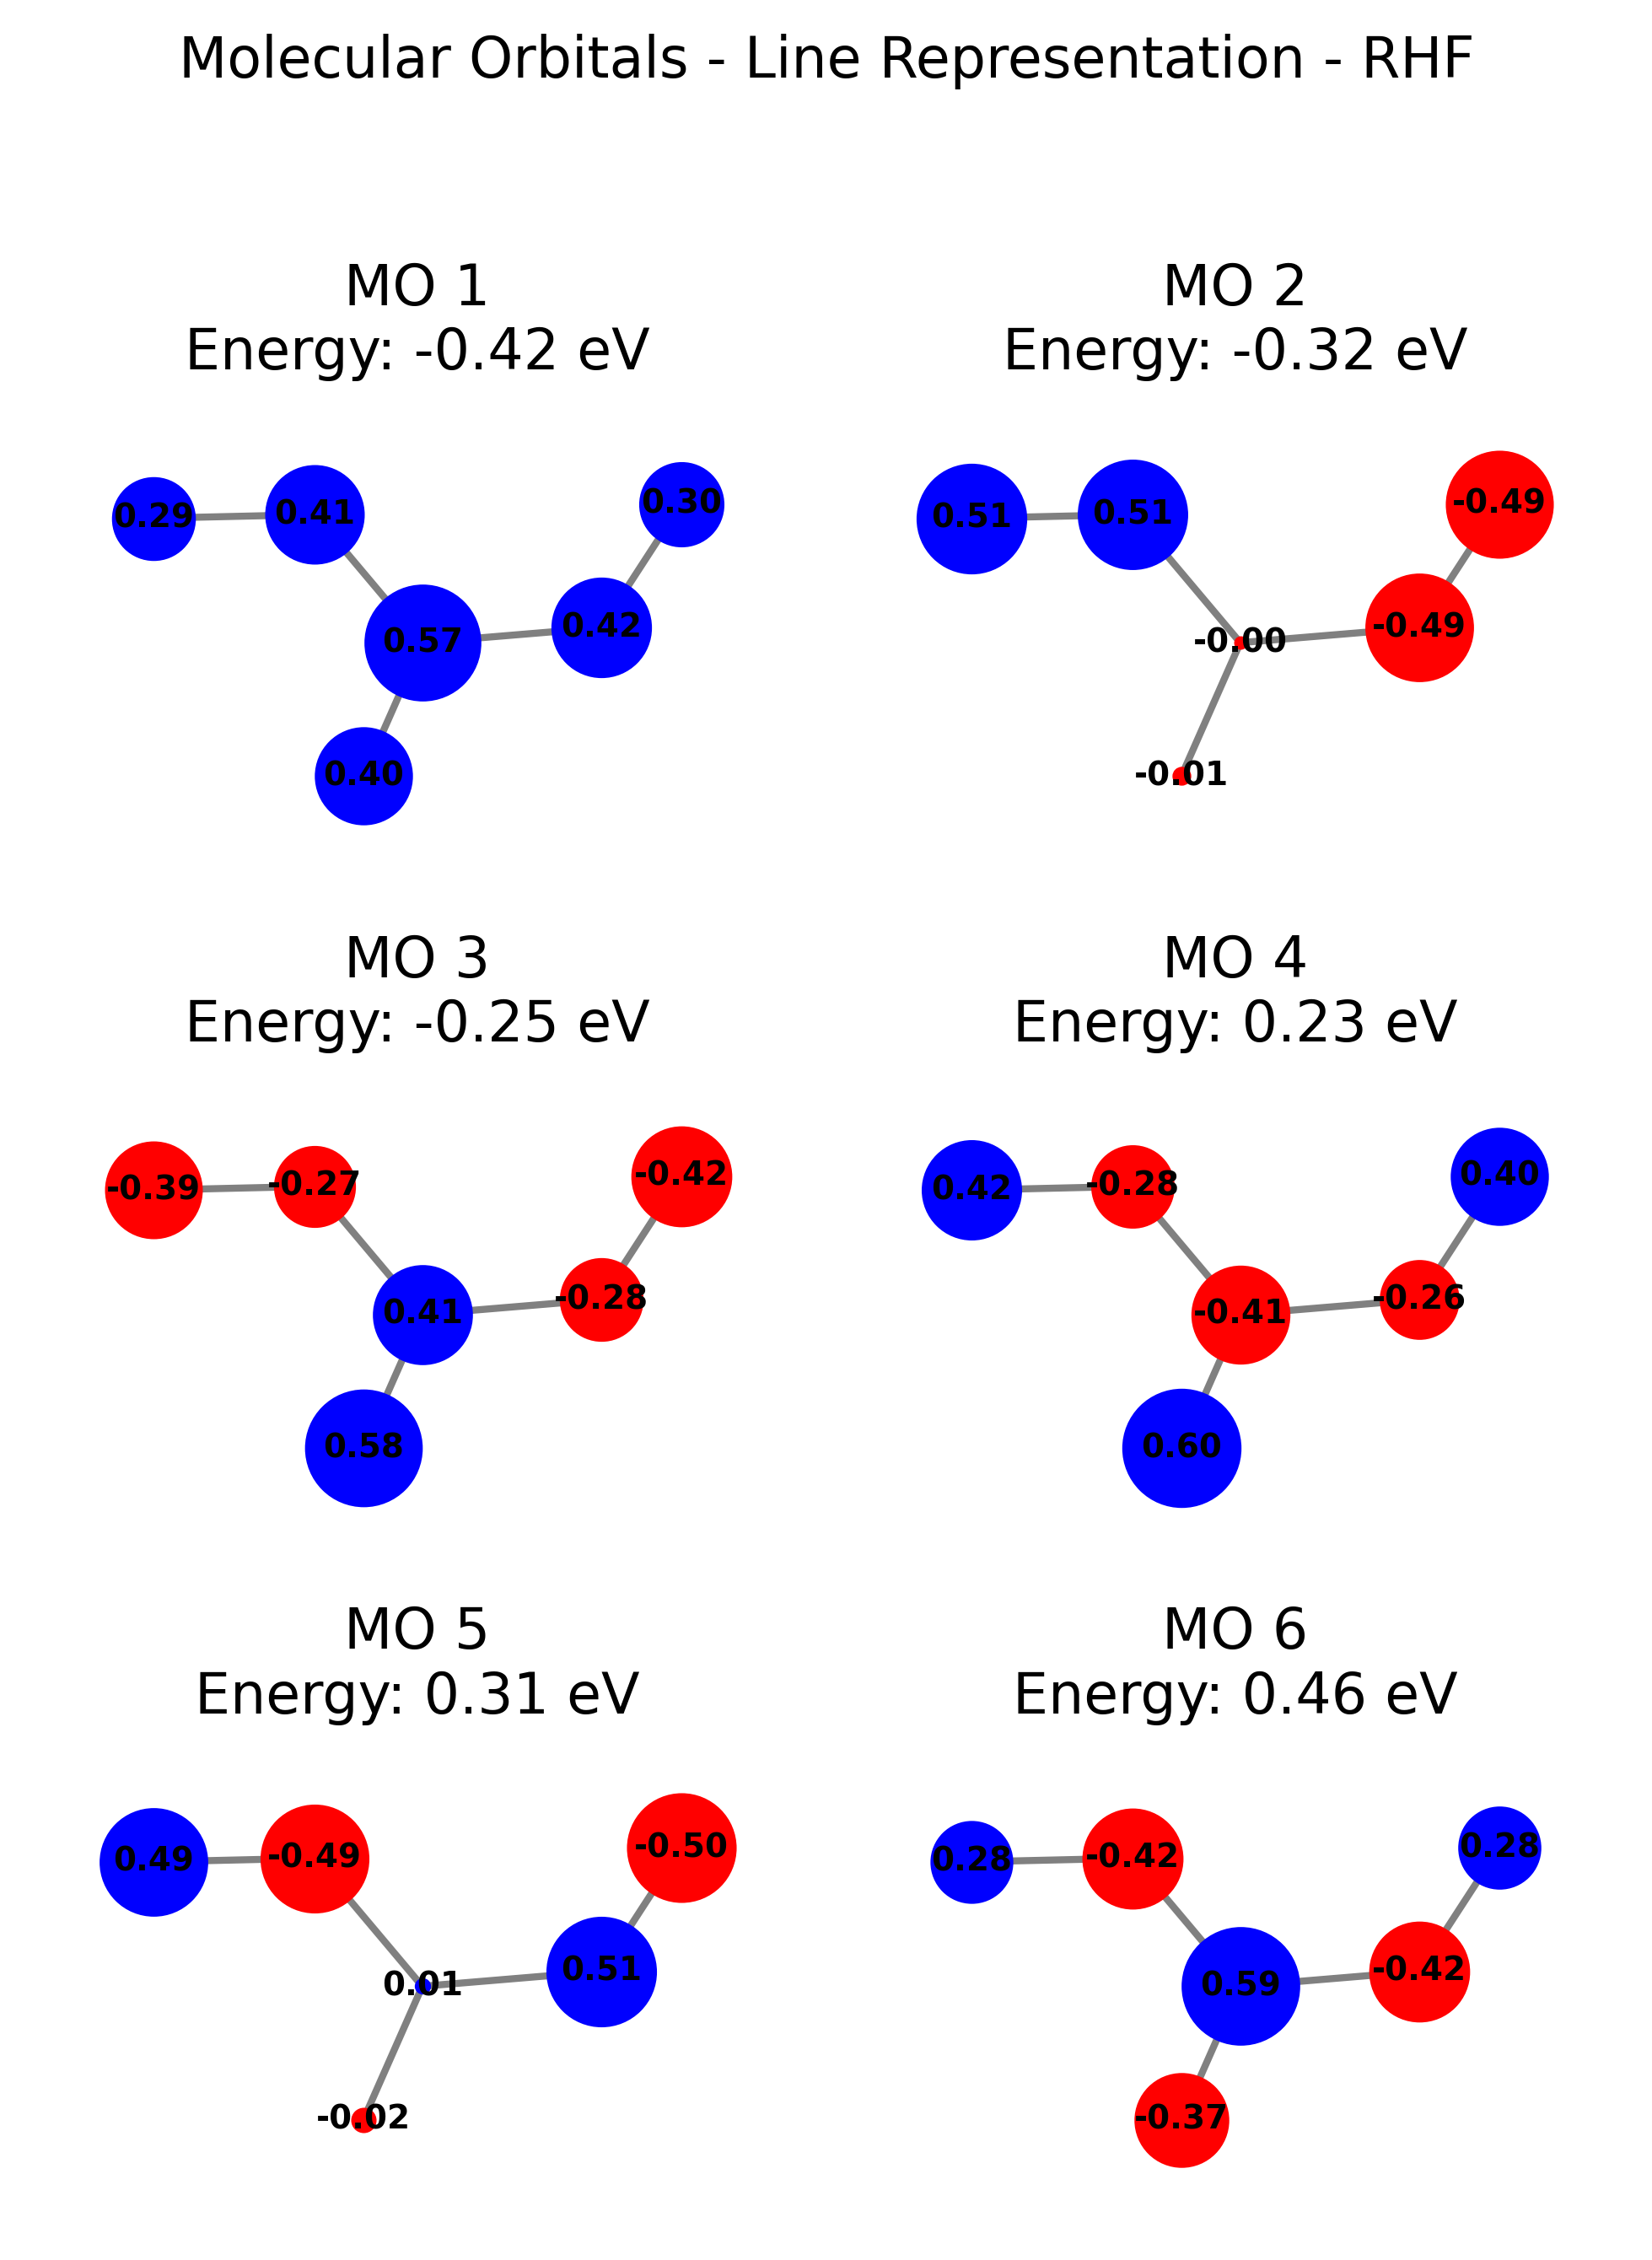

In [76]:
plotting_of_the_system(6, pz_orbitals, mo_eigenvalues, 'RHF', [(0,1), (1,2), (2,3), (2,4), (4,5)])

In [77]:
molecule = """  
  C   -0.0000000   -1.4760186    0.0000000
  C   -0.0000000   -0.1251655    0.0000000
  C   -0.0000000    0.6691580    1.2681380
  C   -0.0000000    0.1622888    2.5095663
  C    0.0000000    0.6691580   -1.2681380
  C    0.0000000    0.1622888   -2.5095663
  H   -0.0000000   -2.0589479    0.9105617
  H   -0.0000000   -2.0589479   -0.9105617
  H    0.0000000    1.7526396    1.1853508
  H   -0.0000000   -0.8985996    2.7198648
  H   -0.0000000    0.8372311    3.3596266
  H    0.0000000    1.7526396   -1.1853508
  H    0.0000000   -0.8985996   -2.7198648
  H    0.0000000    0.8372311   -3.3596266
"""

carbon_lines = [line.split()[1:] for line in molecule.split('\n') if line.startswith('  C')]

# Converteer de coördinaten naar een NumPy-array
carbon_coordinates = np.array(carbon_lines, dtype=float)

print(carbon_coordinates)
_molecule = gto.M(atom=molecule, basis='sto-3g')#'sto-6g''ccpvdz'

pz_indices = [i for i, label in enumerate(_molecule.ao_labels()) if 'C 2px' in label]
print(pz_indices)
hf = scf.RHF(_molecule)
hf_energy = hf.kernel()


[[-0.        -1.4760186  0.       ]
 [-0.        -0.1251655  0.       ]
 [-0.         0.669158   1.268138 ]
 [-0.         0.1622888  2.5095663]
 [ 0.         0.669158  -1.268138 ]
 [ 0.         0.1622888 -2.5095663]]
[2, 7, 12, 17, 22, 27]
converged SCF energy = -228.953690028495


In [78]:
mo_coeff = hf.mo_coeff.round(6)
def normaliseer(eigenvectors):
    eigenvectors = eigenvectors.T
    for index, eigenvector in enumerate(eigenvectors):
        eigenvectors[index] = eigenvector * (np.dot(eigenvector, eigenvector))**(-1/2)
    return eigenvectors.T
mo_coeff = normaliseer(mo_coeff)
print(mo_coeff)

[[ 1.19823662e-02 -0.00000000e+00 -2.26073190e-03 ... -0.00000000e+00
  -0.00000000e+00 -3.35098449e-02]
 [-7.23292603e-03 -0.00000000e+00  1.35946016e-04 ...  0.00000000e+00
   0.00000000e+00  2.68466487e-01]
 [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 ...
 [ 9.66807155e-05 -4.89150677e-03 -4.96152609e-03 ... -1.84919584e-02
   1.95681267e-01  6.25233297e-02]
 [-1.41999801e-04 -6.14333772e-05 -6.44484818e-05 ...  4.97191525e-02
   1.89633548e-01 -6.02650372e-02]
 [-3.82694499e-05 -4.73339135e-05 -5.73994291e-05 ...  3.05504956e-02
  -1.45733121e-01  3.90736897e-03]]


In [79]:
mo_eigenvalues = hf.mo_energy[[19,20,21,22,23,24]]
print(mo_eigenvalues)
pz_orbitals = mo_coeff[pz_indices][:,[19,20,21,22,23,24]]
print(pz_orbitals)

[-0.41821824 -0.31955193 -0.24574512  0.22041465  0.31818807  0.4559129 ]
[[ 0.39378883 -0.          0.5860077   0.59241528  0.         -0.37749027]
 [ 0.57491621 -0.          0.4137642  -0.39848514 -0.          0.59498791]
 [ 0.41603328  0.49970751 -0.278649   -0.27216543  0.50408362 -0.41927018]
 [ 0.2900296   0.50029232 -0.4062657   0.41358535 -0.49588275  0.27560435]
 [ 0.41603328 -0.49970751 -0.278649   -0.27216543 -0.50408362 -0.41927018]
 [ 0.2900296  -0.50029232 -0.4062657   0.41358535  0.49588275  0.27560435]]


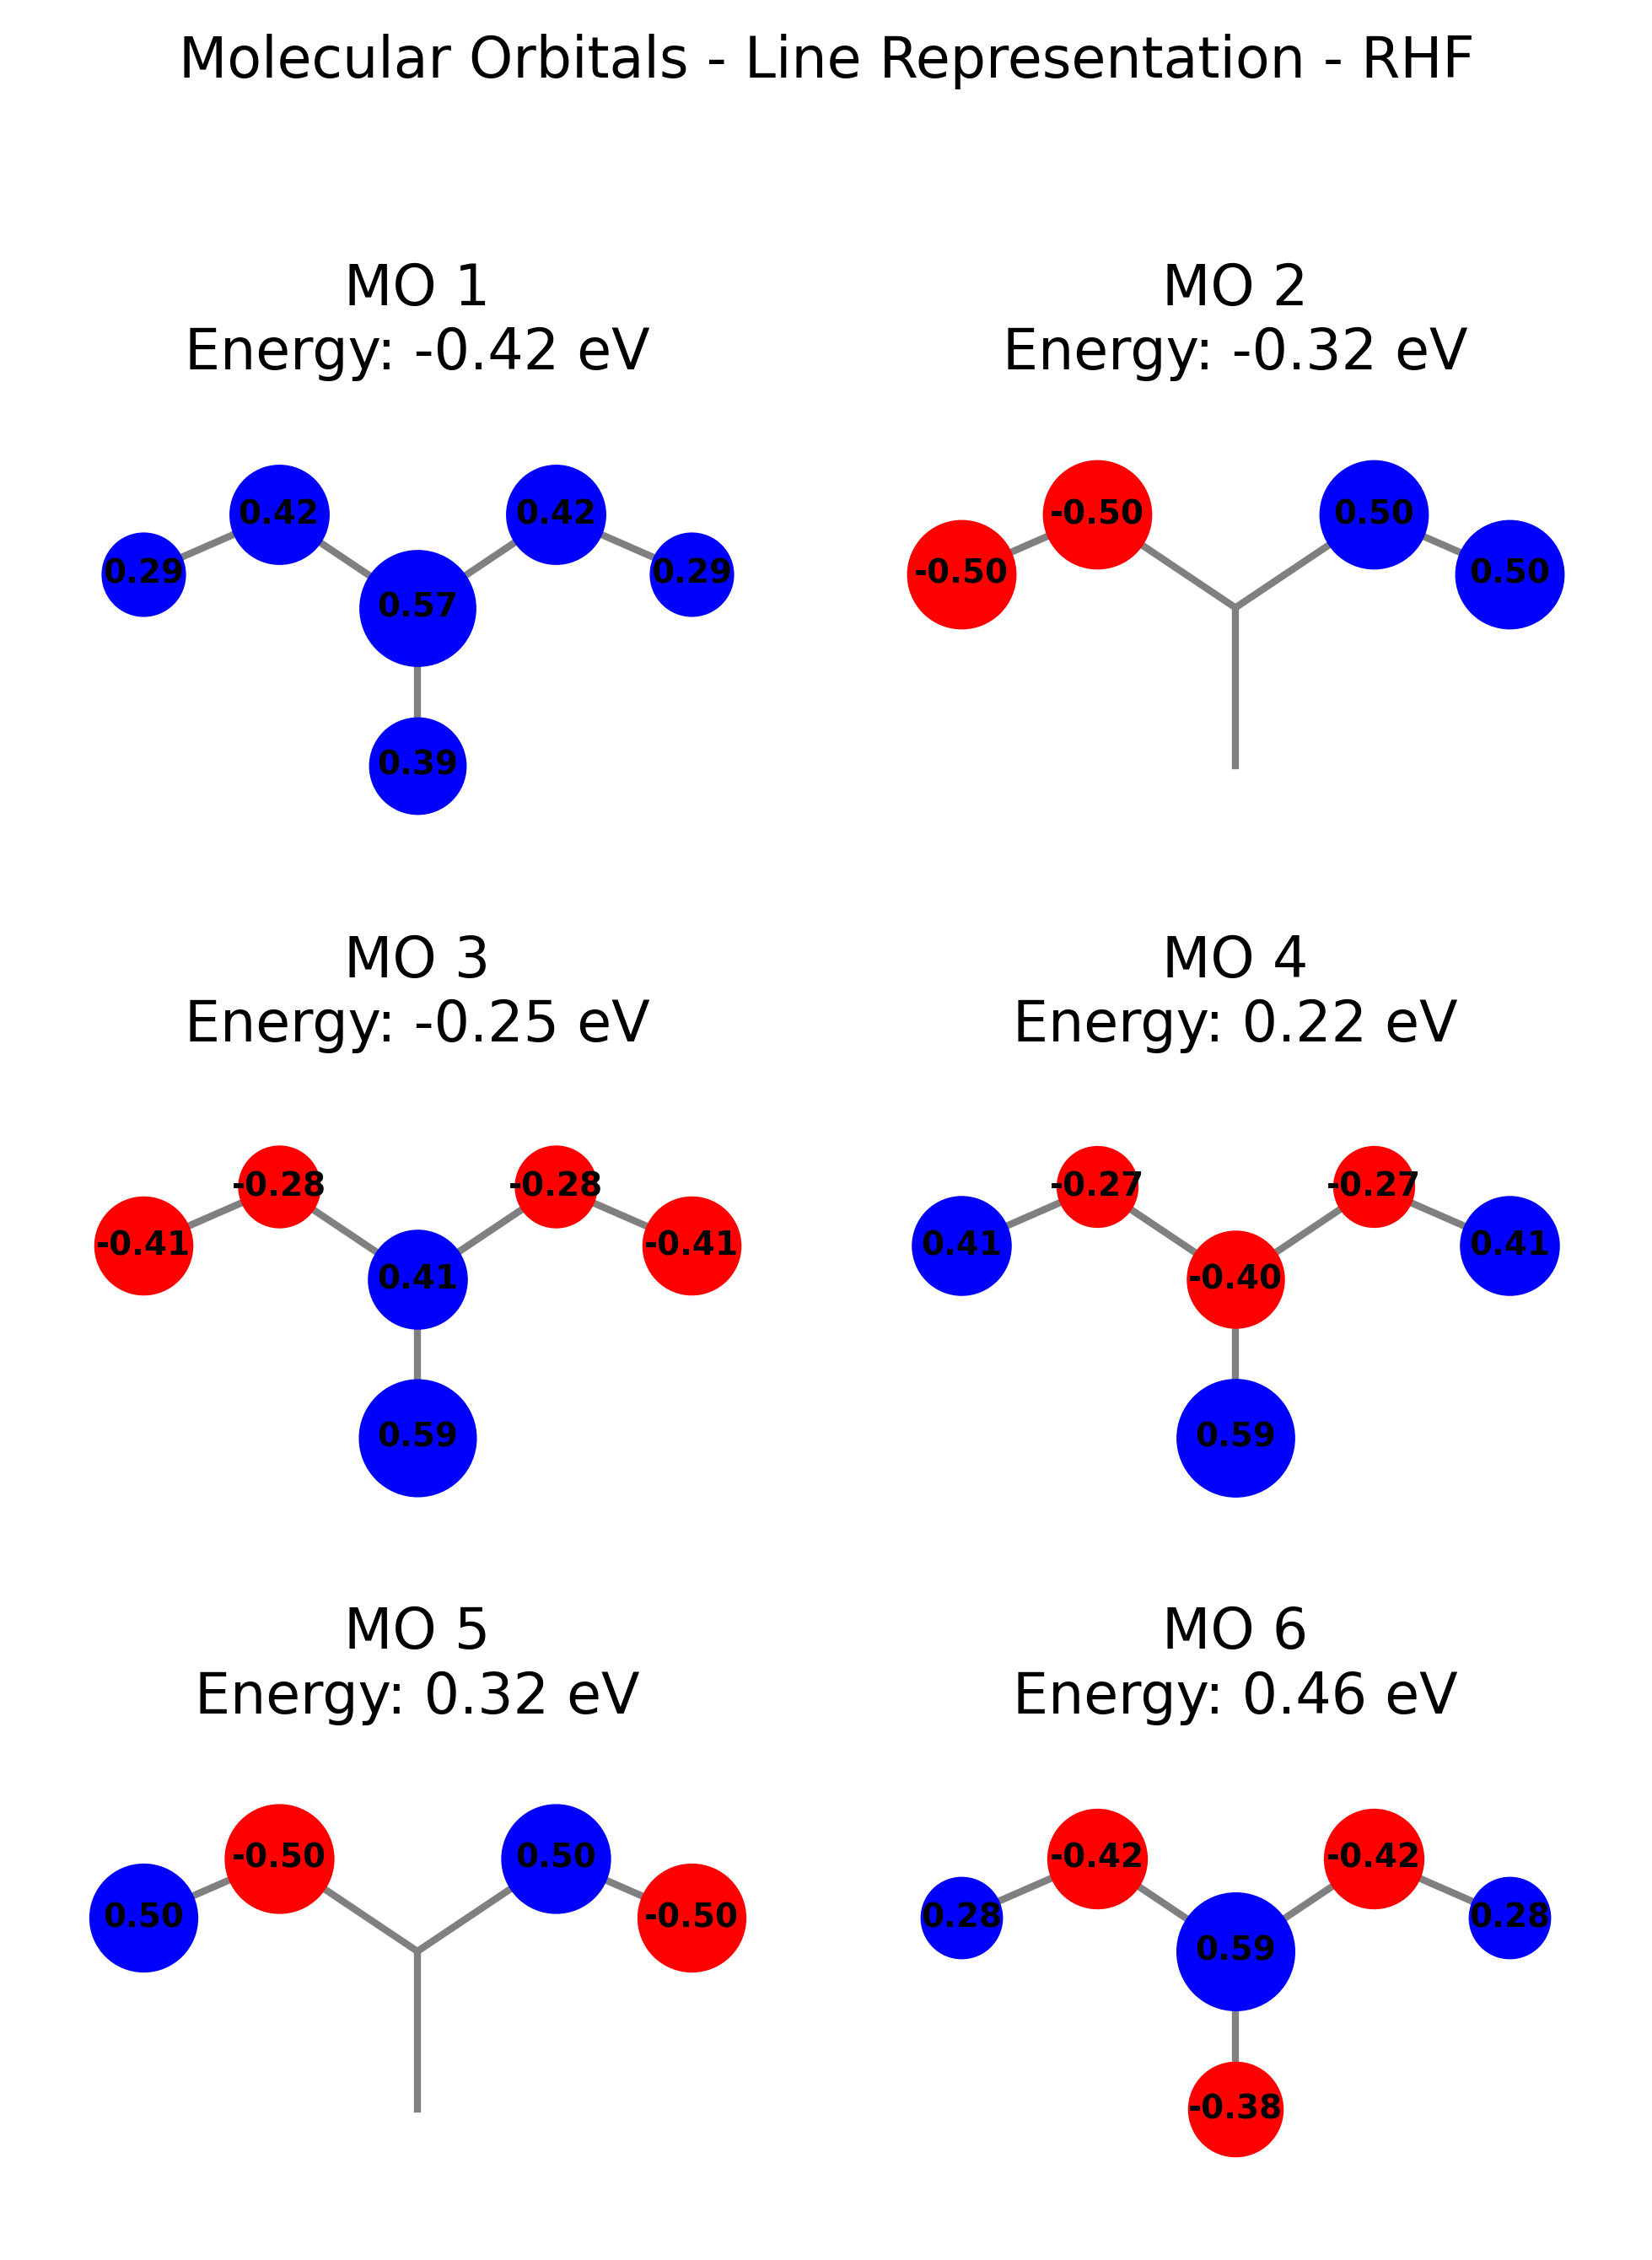

In [80]:
plotting_of_the_system(6, pz_orbitals, mo_eigenvalues, 'RHF', [(0,1), (1,2), (2,3), (1,4), (4,5)])

In [81]:
import sys
sys.path.append('/workspaces/bachelor-project-bridging-profile-Mattice-Criel/projects/Project-MatticeCriel/Benzene/Huckel')
from class_huckel import huckel
other = huckel(6, -2, -1, configuration='lin')
other.create_matrix()
beta = -1
other.huckel_matrix[1, 4] = beta
other.huckel_matrix[4, 1] = beta

other.huckel_matrix[3, 4] = 0
other.huckel_matrix[4, 3] = 0

print(other)

This is the matrix you made.
 [[-2. -1.  0.  0.  0.  0.]
 [-1. -2. -1.  0. -1.  0.]
 [ 0. -1. -2. -1.  0.  0.]
 [ 0.  0. -1. -2.  0.  0.]
 [ 0. -1.  0.  0. -2. -1.]
 [ 0.  0.  0.  0. -1. -2.]]


In [82]:
other.solve_huckel_matrix()
eigenvalues =  other.eigenvalues
print(eigenvalues)
eigenvectors = other.eigenvectors

print(eigenvectors)

[-3.931852 -3.       -2.517638 -1.482362 -1.       -0.068148]
[[ 0.32505792 -0.          0.62796285  0.62796285  0.          0.32505792]
 [ 0.62796285 -0.          0.32505792 -0.32505792 -0.         -0.62796285]
 [ 0.44403705 -0.50000006 -0.22985003 -0.22985003 -0.50000006  0.44403705]
 [ 0.22985003 -0.50000006 -0.44403705  0.44403705  0.50000006 -0.22985003]
 [ 0.44403705  0.50000006 -0.22985003 -0.22985003  0.50000006  0.44403705]
 [ 0.22985003  0.50000006 -0.44403705  0.44403705 -0.50000006 -0.22985003]]


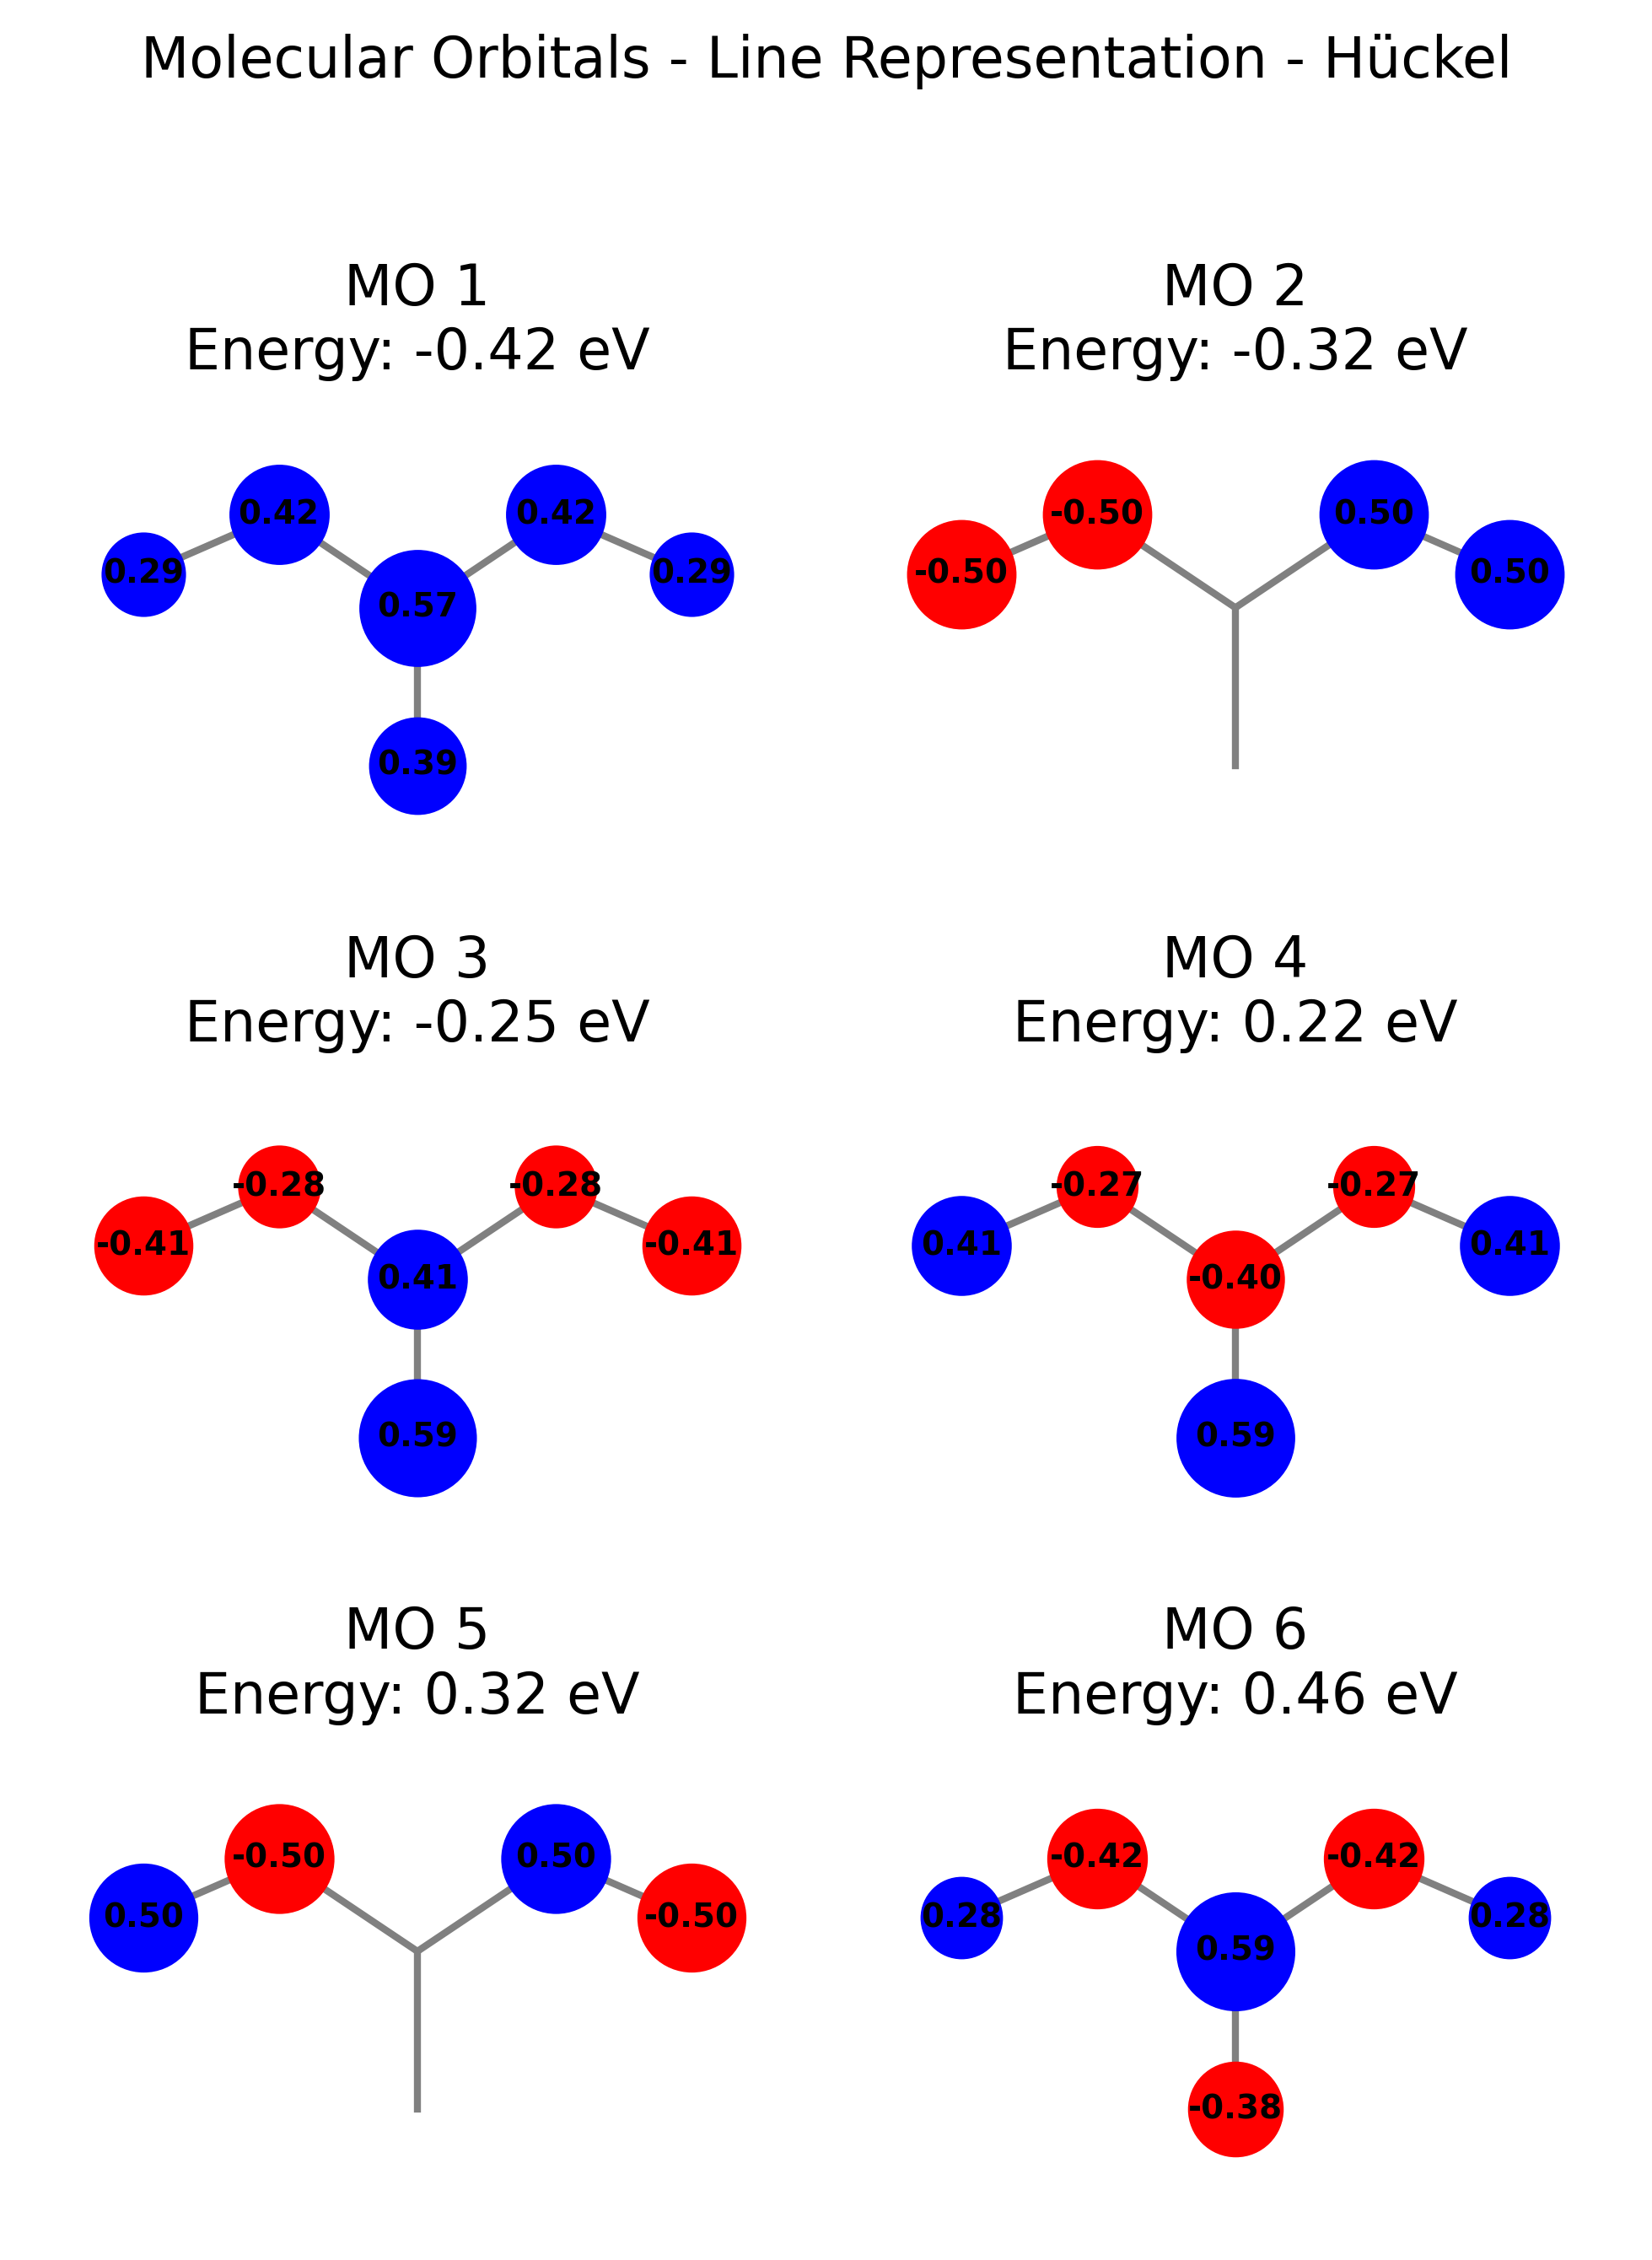

In [83]:
plotting_of_the_system(6, pz_orbitals, mo_eigenvalues, 'Hückel', [(0,1), (1,2), (2,3), (1,4), (4,5)])